# Topic Analysis, Text Classification and Summarisation

## Setting up

In [1]:
import re
import nltk
from nltk.corpus import stopwords
#from sklearn.feature_extraction.text import CountVectorizer
from itertools import chain
import gensim
from gensim import corpora
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
nltk.download()
#need to download 'stopwords' and 'wordnet'

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords


      Unzipping corpora/stopwords.zip.



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> wordnet



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [3]:
#read in the FTA
fta = open("UK-AU-FTA.txt").read()
#split into chapters and then down to articles, remove chapter headings
chapters = re.split('\s*CHAPTER\s+[0-9]+\s*', fta)[1:]
articles_and_chpt_headers = [re.split('\n\s*Article\s[0-9]+.[0-9]+\s*\n', chpt) for chpt in chapters]
articles = [i[1:] for i in articles_and_chpt_headers]
#unnest to get a single list to use in LDA
articles_text = list(chain(*articles))

## Cleaning the text

In [4]:
from nltk.stem.wordnet import WordNetLemmatizer
import string

#bring in a standard set of stopwords and add those that have been found iteratively
stop = set(stopwords.words('english'))
contextual_stopwords = {'good', 'party', 'shall', 'article', 'agreement', 'may',
                        'agreements',  'measure', 'origin', 'custom', 'originating',
                        'paragraph', 'territory', 'provide', 'material', 'value', 
                        'producer', 'non', 'chapter', 'producer', 'information', 
                        'production', 'trade', 'including', 'mean', 'greater', 'apply',
                        'set', 'annex', 'to', 'relating', 'use', 'within', 'ensure',
                        'relevant', 'accordance', 'include', 'provision', 'covered',
                        'recognise', 'certainty', 'condition', 'otherwise', 'matter'}
#define any compound tokens that have been found by analysis
compounds = {'established financial service supplier': 'established-financial-service-supplier',
             'financial service supplier': 'financial-service-supplier',
             'financial service': 'financial-service',
             'cross border service': 'cross-border-service',
             'cross border': 'cross-border',
             'intellectual property right': 'intellectual-property-right',
             'united kingdom': 'united-kingdom',
             'contact point': 'contact-point',
             'non conforming': 'non-conforming',
             'state owned enterprise': 'state-owned-enterprise',
             'working group': 'working-group',
             'joint committee': 'joint-committee',
             'procuring entity': 'procuring-entity',
             'dispute settlement': 'dispute-settlement',
             'telecommunication service': 'telecommunication-service',
             'public telecommunication network service': 'public-telecommunication-network-service',
             'judicial authority': 'judicial-authority',
             'regulatory authority': 'regulatory-authority',
             'favoured nation treatment': 'favoured-nation-treatment',
             'reasonable period time': 'reasonable-period-of-time',
             'regulatory cooperation': 'regulatory-cooperation',
             'time period': 'time-period',
             'without prejudice': 'without-prejudice',
             'bilateral safeguard': 'bilateral-safeguard',
             'competent authority': 'competent-authority',
             'date entry force': 'date-of-entry-into-force',
             'cosmetic product': 'cosmetic-product',
             '30 day': '30-day'}

#set up cleaning function            
exclude = set(string.punctuation+'“”–’')
other_exclusions = set('1234567890abcdefghijk')
lemma = WordNetLemmatizer()
def multiple_replace(string, rep_dict):
    pattern = re.compile("|".join([re.escape(k) for k in sorted(rep_dict,key=len,reverse=True)]), flags=re.DOTALL)
    return pattern.sub(lambda x: rep_dict[x.group(0)], string)
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    context_cleaned = " ".join([i for i in normalized.split() if i not in contextual_stopwords])
    numbers_removed = " ".join([i for i in context_cleaned.split() if i not in other_exclusions])
    roman_numerals_removed = " ".join([re.sub("^M{0,4}(cm|cd|d?c{0,3})(xc|xl|l?x{0,3})(ix|iv|v?i{0,3})$", "", i) 
                                      for i in numbers_removed.lower().split()])
    #can join bigrams with hyphen now
    #bigram1 = roman_numerals_removed.replace('financial service', 'financial-service')
    #but want to do systematically not line by line
    #see example soln in next box
    compounds_joined = multiple_replace(roman_numerals_removed, compounds)
    return compounds_joined

#clean the text
doc_clean = [clean(doc).split() for doc in articles_text]
tokens = list(chain(*doc_clean))

In [46]:
#identify the most common tokens which may be stop words in this context
from collections import Counter
c=Counter(tokens)
print(c.most_common()[:20])

[('service', 506), ('law', 389), ('investment', 344), ('procedure', 310), ('supplier', 307), ('public', 248), ('request', 247), ('person', 243), ('international', 234), ('right', 232), ('provided', 227), ('regulation', 219), ('application', 209), ('requirement', 204), ('purpose', 200), ('respect', 199), ('commercial', 198), ('authority', 196), ('treatment', 186), ('appropriate', 185)]


In [47]:
#identify common bi-grams which may be compound tokens
bigrams = zip(tokens, tokens[1:])
counts = Counter(bigrams)
print(counts.most_common()[:20])

[(('law', 'regulation'), 127), (('commercial', 'assistance'), 62), (('service', 'supplier'), 54), (('national', 'treatment'), 53), (('level', 'government'), 49), (('supply', 'service'), 49), (('adopt', 'maintain'), 46), (('geographical', 'indication'), 45), (('rule', 'procedure'), 38), (('right', 'holder'), 34), (('le', 'favourable'), 33), (('conformity', 'assessment'), 33), (('cooperation', 'activity'), 32), (('publicly', 'available'), 31), (('referred', 'subparagraph'), 31), (('bribery', 'corruption'), 31), (('service', 'investment'), 30), (('30', 'dispute-settlement'), 29), (('treatment', 'le'), 29), (('preferential', 'tariff'), 29)]


In [ ]:
#print an example of cleaned text
print(doc_clean[:2])

[['establishment', 'free', 'area', 'consistent', 'gatt', '1994', 'gat', 'hereby', 'establish', 'free', 'area'], ['relation', 'affirm', 'existing', 'right', 'obligation', 'respect', 'existing', 'international', 'wto', 'considers', 'inconsistent', 'another', 'request', 'consult', 'view', 'reaching', 'mutually', 'satisfactory', 'solution', 'without-prejudice', 'right', 'obligation', '30', 'dispute-settlement', 'long', 'protocol', 'irelandnorthern', 'ireland', 'withdrawal', 'united-kingdom', 'great', 'britain', 'northern', 'ireland', 'european', 'union', 'european', 'atomic', 'energy', 'community', 'signed', 'london', 'brussels', '24', 'january', '2020', 'the', 'protocol', 'force', 'nothing', 'preclude', 'united-kingdom', 'adopting', 'maintaining', 'refraining', 'so', 'protocol', 'amendment', 'thereto', 'subsequent', 'replacing', 'part', 'thereof', 'provided', 'absence', 'used', 'arbitrary', 'unjustified', 'discrimination', 'disguised', 'restriction', 'purpose', 'application', 'agree', 'fa

## Creating an example LDA Model

In [5]:
# create the dictionary, assign each term an index 
dictionary = corpora.Dictionary(doc_clean)
# convert text into a 'document term matric'
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
# setting up the LDA model from gensim
Lda = gensim.models.ldamodel.LdaModel

In [ ]:
# running and training an example LDA model
ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=50)

In [ ]:
print(ldamodel.print_topics(num_topics=5, num_words=5))

[(3, '0.020*"public" + 0.016*"supplier" + 0.011*"service" + 0.009*"person" + 0.008*"law"'), (2, '0.026*"investment" + 0.026*"service" + 0.014*"treatment" + 0.012*"enterprise" + 0.012*"commercial"'), (1, '0.023*"law" + 0.022*"dispute-settlement" + 0.017*"corruption" + 0.017*"labour" + 0.013*"bribery"'), (7, '0.020*"cooperation" + 0.012*"committee" + 0.012*"international" + 0.011*"appropriate" + 0.010*"development"'), (8, '0.011*"duty" + 0.011*"patent" + 0.011*"tariff" + 0.010*"provided" + 0.010*"declaration"')]


## Optimising the number of topics

In [ ]:
#calculating and displaying the coherence score for the example above
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(
   model=ldamodel, texts=doc_clean, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('Coherence Score: ', coherence_lda)

Coherence Score:  0.430048032507879


In [ ]:
#first fitting a number of different models and calculating their coherance scores
topics = range(1, 200, 10)
models = [Lda(doc_term_matrix, num_topics=i, id2word = dictionary, passes=50) for i in topics]
coherences__c_v = [CoherenceModel(model=i, texts=doc_clean, dictionary=dictionary, coherence='c_v').get_coherence() for i in models]
coherence__u_mass = [CoherenceModel(model=i, texts=doc_clean, dictionary=dictionary, coherence='u_mass').get_coherence() for i in models]

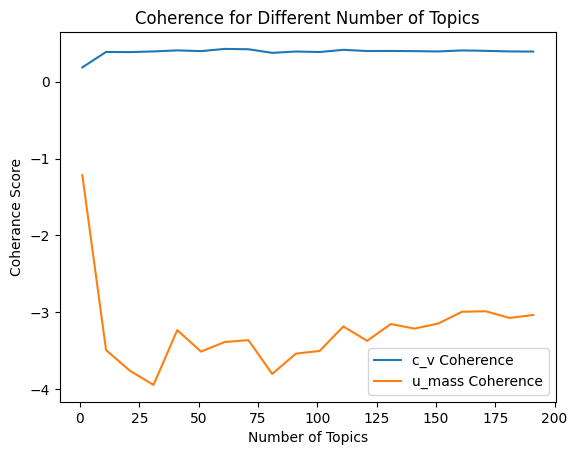

In [ ]:
plt.plot(topics, coherences__c_v)
plt.plot(topics, coherence__u_mass)
plt.title('Coherence for Different Number of Topics')
plt.xlabel('Number of Topics')
plt.locator_params(axis="x", integer=True, tight=True)
plt.ylabel('Coherance Score')
plt.legend(['c_v Coherence','u_mass Coherence'])
plt.show()

In [49]:
#fitting HDP instead
from gensim.models import HdpModel
hdpmodel = gensim.models.hdpmodel.HdpModel(corpus = doc_term_matrix, id2word = dictionary, T = 150)
#print 5 most significant topics
print(hdpmodel.print_topics(num_topics=5))

[(0, '0.004*law + 0.004*service + 0.004*procedure + 0.003*supplier + 0.003*application + 0.003*investment + 0.003*regulation + 0.003*financial-service + 0.003*payment + 0.002*person'), (1, '0.005*cooperation + 0.004*regulatory + 0.004*financial-service + 0.003*consultation + 0.003*service + 0.003*investment + 0.003*activity + 0.003*request + 0.003*policy + 0.003*law'), (2, '0.005*investment + 0.003*procurement + 0.003*service + 0.003*assistance + 0.003*market + 0.003*law + 0.003*commercial + 0.003*like + 0.002*sale + 0.002*price'), (3, '0.003*law + 0.003*application + 0.003*fishing + 0.003*decision + 0.002*service + 0.002*fishery + 0.002*enterprise + 0.002*extent + 0.002*procedure + 0.002*authorisation'), (4, '0.004*panel + 0.003*commercial + 0.003*investment + 0.003*schedule + 0.003*government + 0.002*treatment + 0.002*service + 0.002*conforming + 0.002*respect + 0.002*state-owned-enterprise')]


In [50]:
print(hdpmodel.suggested_lda_model())
#note the number of topics is the same as parameter 'T' (top level truncation)
#this reoccurs no matter what the parameter is set to
#I think because of a lack of distinct topics in the data

LdaModel<num_terms=5266, num_topics=150, decay=0.5, chunksize=2000>


In [53]:
#trying an alternate package
import tomotopy as tp
term_weight = tp.TermWeight.ONE
hdp = tp.HDPModel(tw=term_weight, seed=99999)
for vec in doc_clean:
    hdp.add_doc(vec)
hdp.burn_in = 100
hdp.train(0)
for i in range(0, 1000, 100):
    hdp.train(100)
    print('Topics: {}'.format(hdp.live_k))

<ipython-input-53-a13d2b748b6a>:8: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(0)
<ipython-input-53-a13d2b748b6a>:10: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(100)


Topics: 47
Topics: 57
Topics: 67
Topics: 68
Topics: 71
Topics: 70
Topics: 71
Topics: 74
Topics: 75
Topics: 74


In [48]:
#retrieving topics for this package is challenging, function below provided by Eduardo Sroka
def get_hdp_topics(hdp, top_n=10):
    '''Wrapper function to extract topics from trained tomotopy HDP model 
    
    ** Inputs **
    hdp:obj -> HDPModel trained model
    top_n: int -> top n words in topic based on frequencies
    
    ** Returns **
    topics: dict -> per topic, an arrays with top words and associated frequencies 
    '''
    
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = [k for k, v in sorted(enumerate(hdp.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        if not hdp.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
        topic_wp =[]
        for word, prob in hdp.get_topic_words(k, top_n=top_n):
            topic_wp.append((word, prob))

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics

topics = get_hdp_topics(hdp, top_n=3)
print(topics[:5])

NameError: ignored

## Creating the final LDA Model and interpreting topics

In [6]:
# Running and Training LDA model for an example number of topics
#set seed to create reproducable results
np.random.seed(42)
ldamodel_final = Lda(doc_term_matrix, num_topics=20, id2word = dictionary, passes=50)
print(ldamodel_final.print_topics(num_words=5))

[(0, '0.032*"ruling" + 0.022*"administrative" + 0.020*"advance" + 0.018*"person" + 0.017*"public"'), (1, '0.026*"investment" + 0.025*"financial-service" + 0.022*"service" + 0.010*"treatment" + 0.010*"investor"'), (2, '0.012*"treatment" + 0.012*"service" + 0.011*"requirement" + 0.010*"duty" + 0.010*"tax"'), (3, '0.013*"person" + 0.012*"fishing" + 0.012*"done" + 0.010*"marine" + 0.010*"fishery"'), (4, '0.062*"cooperation" + 0.029*"contact-point" + 0.029*"activity" + 0.024*"committee" + 0.016*"appropriate"'), (5, '0.047*"panel" + 0.034*"report" + 0.023*"obligation" + 0.018*"final" + 0.017*"bilateral-safeguard"'), (6, '0.016*"government" + 0.016*"service" + 0.014*"innovation" + 0.013*"environmental" + 0.012*"investment"'), (7, '0.086*"dispute-settlement" + 0.033*"30" + 0.029*"arising" + 0.023*"recourse" + 0.019*"dispute"'), (8, '0.018*"service" + 0.013*"public" + 0.012*"law" + 0.012*"corruption" + 0.012*"legal"'), (9, '0.038*"right" + 0.030*"phonogram" + 0.028*"work" + 0.025*"public" + 0.0

In [7]:
#create a df of articles and their topics

#start with article titles
articles_and_titles = [re.split('\n', article, maxsplit = 1) for article in articles_text]
article_titles = [a[0] for a in articles_and_titles]
articles_df = pd.DataFrame(article_titles, columns = ['Article'])
#add column for article text
#article_text = [a[1] for a in articles_and_titles]
articles_df['Article Text'] = [a[1] for a in articles_and_titles]
#add column for chapter titles
chpt_titles = [c[0] for c in articles_and_chpt_headers]
chpts = []
for i in range(len(chpt_titles)):
  chpts.append(len(articles[i]) * [chpt_titles[i]])
chpts = list(chain(*chpts))
articles_df['Chapter'] = chpts
#add topics to articles_df
topics = []
for i in range(len(doc_term_matrix)):
  topics.append(ldamodel_final.get_document_topics(doc_term_matrix[i]))
articles_df['LDA Topics'] = topics
#hot encode this, firstly add columns for each topic with zeros
for topic in range(20):
  articles_df['prob_t' + str(topic)] = [0] * len(articles_df)
#then loop through rows and topics to add values
for i in range(len(articles_df['LDA Topics'])):
  row = articles_df['LDA Topics'][i]
  for topic in row:
    articles_df['prob_t' + str(topic[0])][i] = topic[1]

#show first few rows
articles_df.head()

<ipython-input-7-dc8764692b64>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_df['prob_t' + str(topic[0])][i] = topic[1]


,Article,Article Text,Chapter,LDA Topics,prob_t0,prob_t1,prob_t2,prob_t3,prob_t4,prob_t5,...,prob_t10,prob_t11,prob_t12,prob_t13,prob_t14,prob_t15,prob_t16,prob_t17,prob_t18,prob_t19
0,Establishment of a Free Trade Area,"The Parties, consistent with Article XXIV of G...",INITIAL PROVISIONS AND GENERAL DEFINITIONS,"[(2, 0.33747512), (17, 0.58751637)]",0.0,0.000000,0.337475,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.587516,0.000000,0.0
1,Relation to Other Agreements,1. The Parties affirm their existing rights an...,INITIAL PROVISIONS AND GENERAL DEFINITIONS,"[(7, 0.014857361), (16, 0.82338125), (18, 0.15...",0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.823381,0.000000,0.154616,0.0
2,Laws and regulations and their amendments,Where reference is made in this Agreement to l...,INITIAL PROVISIONS AND GENERAL DEFINITIONS,"[(2, 0.4237536), (13, 0.5262392)]",0.0,0.000000,0.423754,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.526239,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,General Definitions,"For the purposes of this Agreement, unless oth...",INITIAL PROVISIONS AND GENERAL DEFINITIONS,"[(1, 0.028184652), (2, 0.5652599), (3, 0.08753...",0.0,0.028185,0.565260,0.087536,0.0,0.0,...,0.0,0.018951,0.024405,0.199245,0.000000,0.000000,0.000000,0.045581,0.000000,0.0
4,Definitions,\nFor the purposes of this Chapter: \n “consu...,TRADE IN GOODS,"[(2, 0.15145011), (6, 0.07816261), (12, 0.2810...",0.0,0.000000,0.151450,0.000000,0.0,0.0,...,0.0,0.000000,0.281040,0.000000,0.260302,0.147503,0.000000,0.071393,0.000000,0.0


In [ ]:
#look at each topic to get some insight into its composition and find a title to give it
articles_df.nlargest(3, ['prob_t5'])

,Article,Article Text,Chapter,LDA Topics,prob_t0,prob_t1,prob_t2,prob_t3,prob_t4,prob_t5,...,prob_t10,prob_t11,prob_t12,prob_t13,prob_t14,prob_t15,prob_t16,prob_t17,prob_t18,prob_t19
438,Compliance Review after the Adoption of Tempor...,1. Compensation and the suspension of concess...,DISPUTE SETTLEMENT,"[(5, 0.9932621)]",0.0,0.0,0.0,0.0,0.0,0.993262,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
272,Criminal Offences,\n1. Each Party shall provide for criminal pr...,INTELLECTUAL PROPERTY \n \n \nSection A \nGe...,"[(5, 0.9912833)]",0.0,0.0,0.0,0.0,0.0,0.991283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,Provisional Application of a Bilateral Safegu...,"\n1. In critical circumstances, a Party may ...",TRADE REMEDIES \n \n \nSection A \nGeneral P...,"[(5, 0.99049896)]",0.0,0.0,0.0,0.0,0.0,0.990499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
#assigning topics their titles and storing together
topic_nums = range(20)
topic_titles = [
    'Corruption and Transparency',
    'Financial Services',
    'Origin of Goods',
    'Maritime Industries',
    'Contact and Cooperation',
    'Trade Safeguards and Remedies',
    'Digital and Environmental Innovation',
    'Dispute Resolution',
    'Workers Rights',
    'Intellectual Property - Protections',
    'State Owned Enterprises',
    'Natural Environment',
    'Shipments and Customers',
    'Consumer Protection',
    'Regulatory Authorities',
    'Digital Trade Facilitation',
    'Information Ownership',
    'Geographical Protections',
    'Disputes in Government Procurement',
    'Supply of Goods'
]
topic_titles = dict(zip(topic_nums, topic_titles))

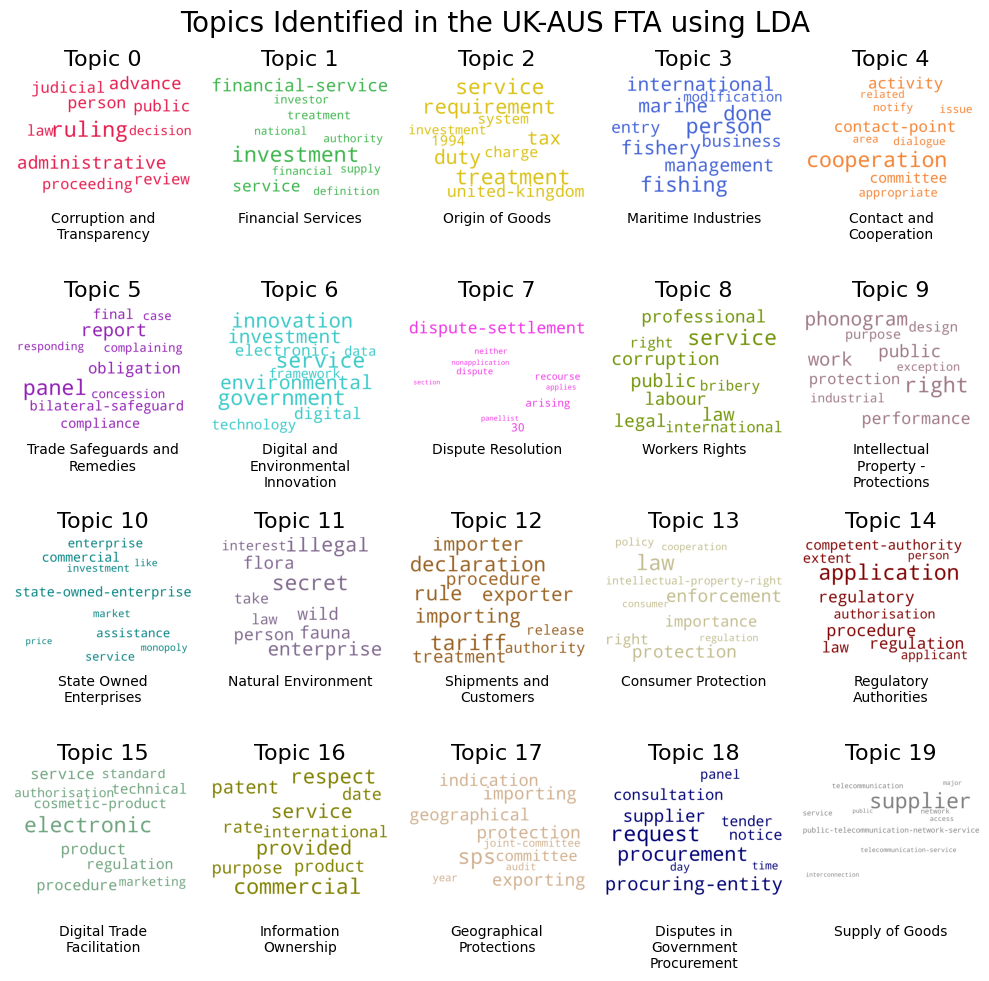

In [ ]:
#visualising this
from wordcloud import WordCloud, STOPWORDS
from textwrap import wrap

cols = ['#e6194b', '#3cb44b', '#dbc114', '#4363d8', '#f58231', '#911eb4', '#3ac9c9', 
        '#f032e6', '#719406', '#9e7886', '#008080', '#816a8f', '#9a6324', '#c2bd8f', 
        '#800000', '#6da37d', '#808000', '#d1b190', '#000075', '#808080']
cloud = WordCloud(stopwords=stop,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
topics = sorted(ldamodel_final.show_topics(num_topics = 20, formatted=False))
fig, axes = plt.subplots(4, 5, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().get_yaxis().set_visible(False)
    plt.xlabel('\n'.join(wrap(topic_titles[i], 20)))
    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.tick_params(colors='white', which='both')
plt.subplots_adjust(wspace=1, hspace=0)
plt.margins(x=0, y=0)
plt.tight_layout()
fig.suptitle('Topics Identified in the UK-AUS FTA using LDA', fontsize=20)
plt.show()

## Creating outputs to be used interactively

In [55]:
#save df of articles and their topic modelling as a csv
articles_df.to_csv('article_topics.csv', index = False)

#use pickle library to save dictionary of topics
import pickle 
with open('topic_dict.pkl', 'wb') as f:
    pickle.dump(topic_titles, f)

## Classifying articles

In [32]:
#create example topic classification
t = 3
l = 0.9 #could be set differently
example_classification = articles_df[articles_df[('prob_t' + str(t))] >= l]

#output final product that could be summarised
example_topic_text = ' '.join(example_classification['Article Text'])
print(example_topic_text[:250])

 
A Party shall not reject a declaration of origin due to minor errors or 
discrepancies, such as slight discrepancies between documents, omissions of information or typing errors, provided these minor discrepancies or errors do not create doubt as t


In [ ]:
#check article lengths
lens = []
for i in range(20):
  t = i 
  classification = articles_df[articles_df[('prob_t' + str(t))] >= l]
  topic_text = ' '.join(classification['Article Text'])
  #count number of words (ie tokens)
  lens.append(len(topic_text.split()))
print("Longest topic has " + str(max(lens)) + " words")

Longest topic has 8286 words


## Recursively summarise this text using BART

In [ ]:
#function for splitting into sections (or chunks) that are not too long to be fed into BART
def summary_chunks(text):
    chunks = []
    #split and join back together to remove odd whitespaces
    remaining_text = " ".join(text.split())
    #loop through and split text off into the list of chunks
    while remaining_text.count('.') > 1:
      words = remaining_text.split()
      stop_index = " ".join(words[0:750]).rfind('.')
      chunks.append(remaining_text[0:stop_index+1])
      remaining_text = remaining_text[stop_index+1:]
    #have to remove some specific sections which tokenise into too many words in an unhelpful way in BART's tokeniser
    chunks = [c.replace('𝑅𝑅𝑅𝑅𝑅𝑅 = 𝑣𝑣𝑣𝑣𝑣𝑣𝑣𝑣𝑣𝑣 𝑜𝑜𝑜𝑜 𝑡𝑡ℎ𝑣𝑣 𝑔𝑔𝑜𝑜𝑜𝑜𝑔𝑔 − 𝑣𝑣𝑣𝑣 𝑣𝑣𝑣𝑣𝑣𝑣 𝑜𝑜𝑜𝑜 𝑛𝑛𝑜𝑜𝑛𝑛−𝑜𝑜𝑜𝑜𝑜𝑜𝑔𝑔𝑜𝑜𝑛𝑛𝑣𝑣𝑡𝑡𝑜𝑜𝑛𝑛𝑔𝑔 𝑚𝑚𝑣𝑣𝑡𝑡𝑣𝑣𝑜𝑜 𝑜𝑜𝑣𝑣𝑣𝑣𝑚𝑚 𝑣𝑣𝑣𝑣𝑣𝑣𝑣𝑣𝑣𝑣 𝑜𝑜𝑜𝑜 𝑡𝑡ℎ𝑣𝑣 𝑔𝑔𝑜𝑜𝑜𝑜𝑔𝑔', '') for c in chunks]
    chunks = [c.replace('𝑅𝑅𝑅𝑅𝑅𝑅 = 𝑣𝑣𝑣𝑣𝑣𝑣𝑣𝑣𝑣𝑣 𝑜𝑜𝑜𝑜 𝑜𝑜𝑜𝑜𝑜𝑜𝑔𝑔𝑜𝑜𝑛𝑛𝑣𝑣𝑡𝑡𝑜𝑜𝑛𝑛𝑔𝑔 𝑚𝑚𝑣𝑣𝑡𝑡𝑣𝑣𝑜𝑜 𝑜𝑜𝑣𝑣𝑣𝑣𝑚𝑚 𝑣𝑣𝑣𝑣𝑣𝑣𝑣𝑣𝑣𝑣 𝑜𝑜𝑜𝑜 𝑡𝑡ℎ𝑣𝑣 𝑔𝑔𝑜𝑜𝑜𝑜𝑔𝑔×100', '') for c in chunks]
    return chunks

#check topics have been split up as expected
example_text_chunks = summary_chunks(example_topic_text)
print(len(example_text_chunks)) #should be more than 1

In [23]:
#import the model
from transformers import BartForConditionalGeneration, BartTokenizer, BartConfig
# load a pre-trained model and tokenizer 'bart-large-cnn'
tokeniser = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

In [33]:
#run a test
example_classification = articles_df[articles_df[('prob_t' + str(t))] >= l]
example_topic_text = ' '.join(example_classification['Article Text'])
example_text_chunks = summary_chunks(example_topic_text)
inputs = [tokeniser.batch_encode_plus([text],return_tensors='pt') for text in example_text_chunks]

#check lengths after being put through tokeniser
for i in range(len(inputs)):
  print(len(inputs[i]['input_ids'][0]))
#none should be over 1024

781
936
899
108


In [34]:
# encode each piece of text
summary_ids = [model.generate(i['input_ids'], early_stopping=True) for i in inputs]
# Decoding each summary and check we have the right number of them
bart_summaries = [tokeniser.decode(ids[0], skip_special_tokens=True) for ids in summary_ids]
print(len(bart_summaries)) #should be the same as the original number of chunks of text

4


In [35]:
#join together each summary to a single piece
single_sum = ' '.join(bart_summaries)
input = tokeniser.batch_encode_plus([single_sum],return_tensors='pt')
summary_id = model.generate(input['input_ids'], early_stopping=True)
final_sum = tokeniser.decode(summary_id[0], skip_special_tokens=True)
print(final_sum)

A Party may refuse to issue an immigration formality to a business person of the other Party if the temporary entry of that person might affect adversely the settlement of any labour dispute. The Parties acknowledge that inadequate fisheries management, fisheries subsidies that contribute to overfishing and overcapacity, and illegal, unreported, and unregulated ( “IUU” ) fishing 10 can have significant negative impacts on trade, development and the environment.


## Pre-generate summaries to be used in app

In [38]:
l = 0.9
summaries = []
pre_recursive_summaries = []
for t in range(20):
  example_classification = articles_df[articles_df[('prob_t' + str(t))] >= l]
  example_topic_text = ' '.join(example_classification['Article Text'])
  example_text_chunks = summary_chunks(example_topic_text)
  inputs = [tokeniser.batch_encode_plus([text],return_tensors='pt') for text in example_text_chunks]
  summary_ids = [model.generate(i['input_ids'], early_stopping=True) for i in inputs]
  bart_summaries = [tokeniser.decode(ids[0], skip_special_tokens=True) for ids in summary_ids]
  single_sum = ' '.join(bart_summaries)
  pre_recursive_summaries.append(single_sum)
  input = tokeniser.batch_encode_plus([single_sum],return_tensors='pt')
  summary_id = model.generate(input['input_ids'], early_stopping=True)
  final_sum = tokeniser.decode(summary_id[0], skip_special_tokens=True)
  print(str(t)) #print the step in order to keep track of progress
  summaries.append(final_sum)
print(summaries)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
['E ach Party affirms its rights and obligations under Article VI of GATT 1994, the AD Agreement, and the SCM Agreement. Each Party shall issue, prior to the importation of a good of the other Party into its territory, a written advance ruling at the written request of an importer. Within five years of the date of entry into force of this Agreement, the Parties shall conduct further negotiations.', '“Financial service ” means any service of a financial nature, including all insurance and insurance related services. Banking and other financial services ( excluding insurance) is defined in Article 9.9A - 4 United Kingdom. The Parties shall promote and seek to further develop regulatory cooperation in financial services in accordance with Annex 9C. A Party may rescind its decision to defer to the regulatory and supervisory frameworks of the other Party in a specific area of financial services.', 'Each Party shall accord national treatment 

In [44]:
#output results to be used
with open('summaries.pkl', 'wb') as f:
    pickle.dump(summaries, f)
with open('pre_recursive_summaries.pkl', 'wb') as f:
    pickle.dump(pre_recursive_summaries, f)